# Reinforcement learning

In this notebook, we give some example of reinforcement algorithm for a pendulum model. Beware that the implementation of the algorithms are ment to be simple, hence are not super efficient: don't use them as reference if you want to implement some dedicated RL for another problem

In [1]:
import numpy as np
from numpy.linalg import norm,inv,pinv,svd,eig
import matplotlib.pyplot as plt
import time
import random

## Environments

We are going to work with an inverted pendulum with limited torque, that must swing to collect energy before raising up to the unstable equilibrium state. As the algorithms that we are going to explore are either working on discrate action-state spaces, or continuous ones, several versions of this environment are proposed. In general, they all work the same: get in random initial configuration with reset, display in meshcat with render, and run a simulation step with step(control). Examples:

In [2]:
from tp7.env_pendulum import EnvPendulum,EnvPendulumDiscrete,EnvPendulumHybrid,EnvPendulumSinCos

In [3]:
env = EnvPendulum(1,viewer='meshcat')
env.name = str(env.__class__)
env.u0 = np.zeros(env.nu)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7010/static/


In [4]:
env.jupyter_cell()

In [5]:
env.render()
for i in range(10):
    env.step(env.u0)
    env.render()


We define here 4 main environments that you can similarly test:

- EnvPendulum:    state NX=2 continuous, control NU=1 continuous, Euler integration step with DT=1e-2 and high friction
- EnvPendulumDiscrete:  state NX=441 discrete, control NU=11 discrete, Euler step DT=0.5 low friction
- EnvPendulumSinCos: state NX=3 with x=[cos,sin,vel], control NU=1 control, Euler step DT=1e-2, high friction
- EnvPendulumHybrid:  state NX=3 continuous with x=[cos,sin,vel], control NU=11 discrete, Euler step DT=0.5 low friction


## Value iteration

For the first algorithm, we implement a Value iteration, which is an algorithm working on discrete states and discrete actions. As it is not very efficient, we must coarsly discretize the pendulum. Here is the implementation.

Seed = 1188
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7011/static/
Episode #20 done with average cost 0.00
Episode #40 done with average cost 0.05
Episode #60 done with average cost 0.10
Episode #80 done with average cost 9.45
Episode #100 done with average cost 28.95
Episode #120 done with average cost 36.00
Episode #140 done with average cost 36.70
Episode #160 done with average cost 38.95
Episode #180 done with average cost 39.85
Episode #200 done with average cost 41.15
Episode #220 done with average cost 40.85
Episode #240 done with average cost 41.25
Episode #260 done with average cost 41.00
Episode #280 done with average cost 40.65
Episode #300 done with average cost 41.95
Episode #320 done with average cost 41.55
Episode #340 done with average cost 39.80
Episode #360 done with average cost 41.55
Episode #380 done with average cost 41.75
Total rate of success: 32.030


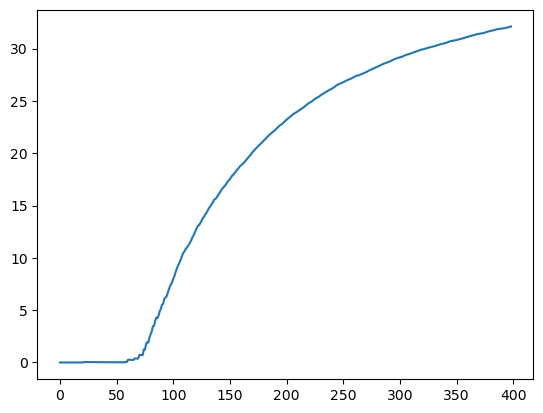

In [6]:
# %load tp7/qtable.py
'''
Example of Q-table learning with a simple discretized 1-pendulum environment.
-- concerge in 1k  episods with pendulum(1)
-- Converge in 10k episods with cozmo model
'''

import matplotlib.pyplot as plt
import signal
import time
import numpy as np

### --- Random seed
RANDOM_SEED = 1188 #int((time.time()%10)*1000)
print("Seed = %d" % RANDOM_SEED)
np.random.seed(RANDOM_SEED)

### --- Environment
from tp7.env_pendulum import EnvPendulumDiscrete; Env = lambda : EnvPendulumDiscrete(1,viewer='meshcat')
env = Env()

### --- Hyper paramaters
NEPISODES               = 400           # Number of training episodes
NSTEPS                  = 50            # Max episode length
LEARNING_RATE           = 0.85          # 
DECAY_RATE              = 0.99          # Discount factor 

Q     = np.zeros([env.nx,env.nu])       # Q-table initialized to 0

def policy(s):
    return np.argmax(Q[s,:])

def rendertrial(s0=None,maxiter=100):
    '''Roll-out from random state using greedy policy.'''
    s = env.reset(s0)
    for i in range(maxiter):
        a = np.argmax(Q[s,:])
        s,r = env.step(a)
        env.render()
    
signal.signal(signal.SIGTSTP, lambda x,y:rendertrial()) # Roll-out when CTRL-Z is pressed

h_rwd = []                              # Learning history (for plot).
for episode in range(1,NEPISODES):
    x    = env.reset()
    rsum = 0.0
    for steps in range(NSTEPS):
        u         = np.argmax(Q[x,:] + np.random.randn(1,env.nu)/episode) # Greedy action with noise
        x2,reward = env.step(u)
        
        # Compute reference Q-value at state x respecting HJB
        Qref = reward + DECAY_RATE*np.max(Q[x2,:])

        # Update Q-Table to better fit HJB
        Q[x,u] += LEARNING_RATE*(Qref-Q[x,u])
        x       = x2
        rsum   += reward

    h_rwd.append(rsum)
    if not episode%20:
        print('Episode #%d done with average cost %.2f' % (episode,sum(h_rwd[-20:])/20))

print("Total rate of success: %.3f" % (sum(h_rwd)/NEPISODES))
rendertrial()
plt.plot( np.cumsum(h_rwd)/range(1,NEPISODES) )
plt.show()



In [10]:
env.jupyter_cell()

After convergence, you can try the obtained policy using the method <rendertrial>.

In [11]:
rendertrial(maxiter=NSTEPS)

Let's display the optimal flow. As states are denoted by their indexes, we need to recover the 2d state from the index, with the following method:

In [12]:
def x2d(s):
    return env.decode_x(s)

In [13]:
from tp7.flow import plotFlow

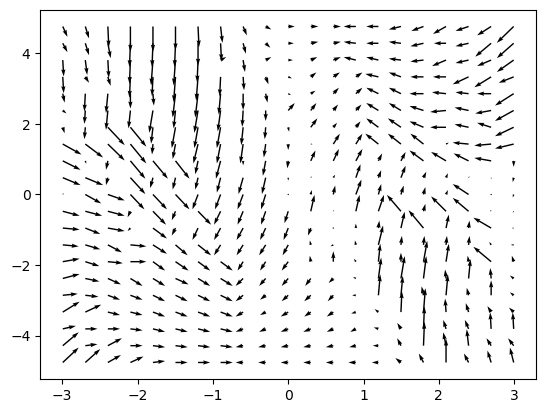

In [14]:
plotFlow(env,policy,x2d)

## Value iteration with a neural network

Next, we marginally modifies the value iteration to store the Q function not as a table, but as a neural network. The main modification will be that the Belman contraction must now be achieve with a gradient descent ... and that is much less efficient. Let's see, on the same environment first.


2023-01-20 18:56:45.544086: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Seed = 6887
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7010/static/


2023-01-20 18:56:47.342893: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-20 18:56:47.372433: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-20 18:56:47.394686: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-20 18:56:47.395018: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

Episode #20 done with 0 sucess
Episode #40 done with 0 sucess
Episode #60 done with 0 sucess
Episode #80 done with 1 sucess
Episode #100 done with 0 sucess
Episode #120 done with 0 sucess
Episode #140 done with 0 sucess
Episode #160 done with 0 sucess
Episode #180 done with 0 sucess
Episode #200 done with 1 sucess
Episode #220 done with 0 sucess
Episode #240 done with 0 sucess
Episode #260 done with 0 sucess
Episode #280 done with 0 sucess
Episode #300 done with 0 sucess
Episode #320 done with 0 sucess
Episode #340 done with 0 sucess
Episode #360 done with 0 sucess
Episode #380 done with 0 sucess
Episode #400 done with 0 sucess
Episode #420 done with 0 sucess
Episode #440 done with 0 sucess
Episode #460 done with 0 sucess
Episode #480 done with 0 sucess
Episode #500 done with 1 sucess
Episode #520 done with 0 sucess
Episode #540 done with 0 sucess
Episode #560 done with 0 sucess
Episode #580 done with 0 sucess
Episode #600 done with 0 sucess
Episode #620 done with 0 sucess
Episode #640

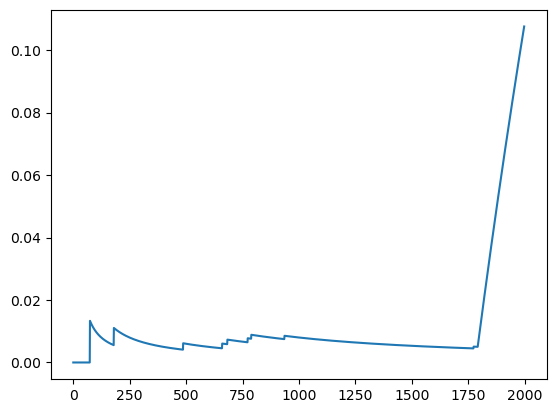

In [1]:
'''
Example of Q-table learning with a simple discretized 1-pendulum environment using a linear Q network.
'''

import numpy as np
import random
import tensorflow as tf
import tensorflow.compat.v1 as tf1
import matplotlib.pyplot as plt
from tp7.env_pendulum import EnvPendulumDiscrete; Env = lambda : EnvPendulumDiscrete(1,viewer='meshcat')
import signal
import time
tf1.disable_eager_execution()


### --- Random seed
RANDOM_SEED = int((time.time()%10)*1000)
print("Seed = %d" % RANDOM_SEED)
np.random.seed(RANDOM_SEED)

### --- Hyper paramaters
NEPISODES               = 2000          # Number of training episodes
NSTEPS                  = 50            # Max episode length
LEARNING_RATE           = 0.1           # Step length in optimizer
DECAY_RATE              = 0.99          # Discount factor 

### --- Environment
env = Env()
NX  = env.nx
NU  = env.nu

### --- Q-value networks
class QValueNetwork:
    def __init__(self):
        x               = tf1.placeholder(shape=[1,NX],dtype=tf.float32)
        W               = tf1.Variable(tf1.random_uniform([NX,NU],0,0.01,seed=100))
        qvalue          = tf1.matmul(x,W)
        u               = tf1.argmax(qvalue,1)

        qref            = tf1.placeholder(shape=[1,NU],dtype=tf.float32)
        loss            = tf1.reduce_sum(tf.square(qref - qvalue))
        optim           = tf1.train.GradientDescentOptimizer(LEARNING_RATE).minimize(loss)

        self.x          = x             # Network input
        self.qvalue     = qvalue        # Q-value as a function of x
        self.u          = u             # Policy  as a function of x
        self.qref       = qref          # Reference Q-value at next step (to be set to l+Q o f)
        self.optim      = optim         # Optimizer      

### --- Tensor flow initialization
#tf.reset_default_graph()
qvalue  = QValueNetwork()
sess = tf1.InteractiveSession()
tf1.global_variables_initializer().run()

def onehot(ix,n=NX):
    '''Return a vector which is 0 everywhere except index <i> set to 1.'''
    return np.array([[ (i==ix) for i in range(n) ],],float)
   
def disturb(u,i):
    u += int(np.random.randn()*10/(i/50+10))
    return np.clip(u,0,NU-1)

def rendertrial(maxiter=100):
    x = env.reset()
    for i in range(maxiter):
        u = sess.run(qvalue.u,feed_dict={ qvalue.x:onehot(x) })
        x,r = env.step(u)
        env.render()
        if r==1: print('Reward!'); break
signal.signal(signal.SIGTSTP, lambda x,y:rendertrial()) # Roll-out when CTRL-Z is pressed

### --- History of search
h_rwd = []                              # Learning history (for plot).

### --- Training
for episode in range(1,NEPISODES):
    x    = env.reset()
    rsum = 0.0

    for step in range(NSTEPS-1):
        u = sess.run(qvalue.u,feed_dict={ qvalue.x: onehot(x) })[0] # Greedy policy ...
        u = disturb(u,episode)                                      # ... with noise
        x2,reward = env.step(u)

        # Compute reference Q-value at state x respecting HJB
        Q2        = sess.run(qvalue.qvalue,feed_dict={ qvalue.x: onehot(x2) })
        Qref      = sess.run(qvalue.qvalue,feed_dict={ qvalue.x: onehot(x ) })
        Qref[0,u] = reward + DECAY_RATE*np.max(Q2)

        # Update Q-table to better fit HJB
        sess.run(qvalue.optim,feed_dict={ qvalue.x    : onehot(x),
                                          qvalue.qref : Qref       })

        rsum += reward
        x = x2
        if reward == 1: break

    h_rwd.append(rsum)
    if not episode%20: print('Episode #%d done with %d sucess' % (episode,sum(h_rwd[-20:])))

print("Total rate of success: %.3f" % (sum(h_rwd)/NEPISODES))
rendertrial()
plt.plot( np.cumsum(h_rwd)/range(1,NEPISODES) )
plt.show()



See? Each step is much more costly (partly due to the poor implementation, but a gradient step is certainly more costly than a table update), and much less informative: the algorithm is slower to converge.

## Q-learning

The good point is that the algorithm scales well for more complex problem, and efficient Q-learning can be implemented on very large one (if you have enough CPUs). Let's take a look at the main one, the Deep-Q algorithm. The input of the neural network can be basically anything (discrete, continuous, an image, etc), the only limitation is that the control must remain discrete, and not too large. So let's take an hybrid version of the same pendulum, with continuous state space (cos,sin,velocity) and discrete control.

RESTART YOUR JUPYTER KERNEL

2023-01-20 19:02:03.808256: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Seed = 5121
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7010/static/


2023-01-20 19:02:05.600988: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-20 19:02:05.623350: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-20 19:02:05.623677: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-20 19:02:05.624262: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Ep#  1: lasted 59 steps, reward=-231
Ep#  2: lasted 59 steps, reward=-185
Ep#  3: lasted 59 steps, reward=-199
Ep#  4: lasted 59 steps, reward=-223
Ep#  5: lasted 59 steps, reward=-175
Ep#  6: lasted 59 steps, reward=-221
Ep#  7: lasted 59 steps, reward=-205


2023-01-20 19:02:11.509863: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Ep#  8: lasted 59 steps, reward=-227
Ep#  9: lasted 59 steps, reward=-236
Ep# 10: lasted 59 steps, reward=-217
Ep# 11: lasted 59 steps, reward=-219
Ep# 12: lasted 59 steps, reward=-211
Ep# 13: lasted 59 steps, reward=-172
Ep# 14: lasted 59 steps, reward=-204
Ep# 15: lasted 59 steps, reward=-204
Ep# 16: lasted 59 steps, reward=-215
Ep# 17: lasted 59 steps, reward=-172


2023-01-20 19:02:18.582524: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Ep# 18: lasted 59 steps, reward=-165
Ep# 19: lasted 59 steps, reward=-154
Ep# 20: lasted 59 steps, reward=-124
Ep# 21: lasted 59 steps, reward=-178
Ep# 22: lasted 59 steps, reward=-125
Ep# 23: lasted 59 steps, reward=-135
Ep# 24: lasted 59 steps, reward=-146


2023-01-20 19:02:23.520671: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled
2023-01-20 19:02:23.573982: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Ep# 25: lasted 59 steps, reward=-133
Ep# 26: lasted 59 steps, reward=-132
Ep# 27: lasted 59 steps, reward=-146
Ep# 28: lasted 59 steps, reward=-140
Ep# 29: lasted 59 steps, reward=-120
Ep# 30: lasted 59 steps, reward=-129
Ep# 31: lasted 59 steps, reward=-135
Ep# 32: lasted 59 steps, reward=-86
Ep# 33: lasted 59 steps, reward=-145
Ep# 34: lasted 59 steps, reward=-126
Ep# 35: lasted 59 steps, reward=-144
Ep# 36: lasted 59 steps, reward=-137
Ep# 37: lasted 59 steps, reward=-124
Ep# 38: lasted 59 steps, reward=-83
Ep# 39: lasted 59 steps, reward=-121
Ep# 40: lasted 59 steps, reward=-106


2023-01-20 19:02:35.508463: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Ep# 41: lasted 59 steps, reward=-99
Ep# 42: lasted 59 steps, reward=-86
Ep# 43: lasted 59 steps, reward=-40
Ep# 44: lasted 59 steps, reward=-43
Ep# 45: lasted 59 steps, reward=-42
Ep# 46: lasted 59 steps, reward=-41
Ep# 47: lasted 59 steps, reward=-143
Ep# 48: lasted 59 steps, reward=-111
Ep# 49: lasted 59 steps, reward=-35
Ep# 50: lasted 59 steps, reward=-44
Ep# 51: lasted 59 steps, reward=-94
Ep# 52: lasted 59 steps, reward=-41
Ep# 53: lasted 59 steps, reward=-59
Ep# 54: lasted 59 steps, reward=-47
Ep# 55: lasted 59 steps, reward=-79
Ep# 56: lasted 59 steps, reward=-65
Ep# 57: lasted 59 steps, reward=-81
Ep# 58: lasted 59 steps, reward= -0
Ep# 59: lasted 59 steps, reward=-40
Ep# 60: lasted 59 steps, reward=-34
Ep# 61: lasted 59 steps, reward=-33
Ep# 62: lasted 59 steps, reward=-39


2023-01-20 19:02:51.328957: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled
2023-01-20 19:02:51.389437: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled
2023-01-20 19:02:51.411060: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Ep# 63: lasted 59 steps, reward=-44
Ep# 64: lasted 59 steps, reward= -5
Ep# 65: lasted 59 steps, reward= -1
Ep# 66: lasted 59 steps, reward=-40
Ep# 67: lasted 59 steps, reward=-68
Ep# 68: lasted 59 steps, reward=-41
Ep# 69: lasted 59 steps, reward=-39
Ep# 70: lasted 59 steps, reward=-61
Ep# 71: lasted 59 steps, reward=-62
Ep# 72: lasted 59 steps, reward=-47
Ep# 73: lasted 59 steps, reward=-33
Ep# 74: lasted 59 steps, reward=-32
Ep# 75: lasted 59 steps, reward=-49
Ep# 76: lasted 59 steps, reward=-45
Ep# 77: lasted 59 steps, reward=-47
Ep# 78: lasted 59 steps, reward=-39
Ep# 79: lasted 59 steps, reward=-31
Ep# 80: lasted 59 steps, reward=-46
Ep# 81: lasted 59 steps, reward=-39
Ep# 82: lasted 59 steps, reward=-22
Ep# 83: lasted 59 steps, reward=-42
Ep# 84: lasted 59 steps, reward=-44


2023-01-20 19:03:07.397450: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Ep# 85: lasted 59 steps, reward=-109
Ep# 86: lasted 59 steps, reward=-40
Ep# 87: lasted 59 steps, reward=-40
Ep# 88: lasted 59 steps, reward=-66
Ep# 89: lasted 59 steps, reward=-98
Ep# 90: lasted 59 steps, reward=-42
Ep# 91: lasted 59 steps, reward= -1
Ep# 92: lasted 59 steps, reward=-41
Ep# 93: lasted 59 steps, reward=-41
Ep# 94: lasted 59 steps, reward= -1
Ep# 95: lasted 59 steps, reward=-47
Ep# 96: lasted 59 steps, reward=-36
Ep# 97: lasted 59 steps, reward=-35
Ep# 98: lasted 59 steps, reward=-48
Ep# 99: lasted 59 steps, reward=-92
Ep#100: lasted 59 steps, reward=-82
Ep#101: lasted 59 steps, reward=-60
Ep#102: lasted 59 steps, reward=-38
Ep#103: lasted 59 steps, reward=-43
Ep#104: lasted 59 steps, reward=-47
Ep#105: lasted 59 steps, reward=-33
Ep#106: lasted 59 steps, reward=-41


2023-01-20 19:03:23.433440: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Ep#107: lasted 59 steps, reward=-39
Ep#108: lasted 59 steps, reward=-69
Ep#109: lasted 59 steps, reward=-32
Ep#110: lasted 59 steps, reward= -2
Ep#111: lasted 59 steps, reward=-75
Ep#112: lasted 59 steps, reward= -1
Ep#113: lasted 59 steps, reward=-39
Ep#114: lasted 59 steps, reward= -2
Ep#115: lasted 59 steps, reward=-36
Ep#116: lasted 59 steps, reward=-51
Ep#117: lasted 59 steps, reward=-70
Ep#118: lasted 59 steps, reward=-73
Ep#119: lasted 59 steps, reward=-48
Ep#120: lasted 59 steps, reward=-68
Ep#121: lasted 59 steps, reward=-66
Ep#122: lasted 59 steps, reward= -8
Ep#123: lasted 59 steps, reward=-44
Ep#124: lasted 59 steps, reward=-69
Ep#125: lasted 59 steps, reward=-40
Ep#126: lasted 59 steps, reward=-44
Ep#127: lasted 59 steps, reward= -1
Ep#128: lasted 59 steps, reward=-32


2023-01-20 19:03:39.346452: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Ep#129: lasted 59 steps, reward=-43
Ep#130: lasted 59 steps, reward=-41
Ep#131: lasted 59 steps, reward=-41
Ep#132: lasted 59 steps, reward=-40
Ep#133: lasted 59 steps, reward= -1
Ep#134: lasted 59 steps, reward=-42
Ep#135: lasted 59 steps, reward=-43
Ep#136: lasted 59 steps, reward=-33
Ep#137: lasted 59 steps, reward= -2
Ep#138: lasted 59 steps, reward=-32
Ep#139: lasted 59 steps, reward=-62
Ep#140: lasted 59 steps, reward=-39
Ep#141: lasted 59 steps, reward=-37
Ep#142: lasted 59 steps, reward=-41


2023-01-20 19:03:49.401448: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Ep#143: lasted 59 steps, reward=-42
Ep#144: lasted 59 steps, reward=-82
Ep#145: lasted 59 steps, reward=-39
Ep#146: lasted 59 steps, reward=-49
Ep#147: lasted 59 steps, reward=-38
Ep#148: lasted 59 steps, reward=-62
Ep#149: lasted 59 steps, reward=-45
Ep#150: lasted 59 steps, reward=-22
Ep#151: lasted 59 steps, reward=-40
Ep#152: lasted 59 steps, reward=-41
Ep#153: lasted 59 steps, reward=-43
Ep#154: lasted 59 steps, reward=-37
Ep#155: lasted 59 steps, reward=-44
Ep#156: lasted 59 steps, reward=-30


2023-01-20 19:03:59.771601: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Ep#157: lasted 59 steps, reward=-38
Ep#158: lasted 59 steps, reward= -4
Ep#159: lasted 59 steps, reward=-71
Ep#160: lasted 59 steps, reward=-53
Ep#161: lasted 59 steps, reward=-40
Ep#162: lasted 59 steps, reward=-25


2023-01-20 19:04:04.431981: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Ep#163: lasted 59 steps, reward=-46
Ep#164: lasted 59 steps, reward=-79
Ep#165: lasted 59 steps, reward=-36
Ep#166: lasted 59 steps, reward=-38
Ep#167: lasted 59 steps, reward=-41


2023-01-20 19:04:08.029580: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Ep#168: lasted 59 steps, reward=-100
Ep#169: lasted 59 steps, reward= -1


2023-01-20 19:04:09.417462: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Ep#170: lasted 59 steps, reward=-58
Ep#171: lasted 59 steps, reward=-27
Ep#172: lasted 59 steps, reward=-40


2023-01-20 19:04:11.589002: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled
2023-01-20 19:04:11.642776: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled
2023-01-20 19:04:11.672022: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Ep#173: lasted 59 steps, reward=-41
Ep#174: lasted 59 steps, reward= -4
Ep#175: lasted 59 steps, reward=-33
Ep#176: lasted 59 steps, reward=-33
Ep#177: lasted 59 steps, reward= -2
Ep#178: lasted 59 steps, reward=-76
Ep#179: lasted 59 steps, reward=-49
Ep#180: lasted 59 steps, reward=-75
Ep#181: lasted 59 steps, reward=-40
Ep#182: lasted 59 steps, reward=-37
Ep#183: lasted 59 steps, reward=-37
Ep#184: lasted 59 steps, reward=-46
Ep#185: lasted 59 steps, reward=-41
Ep#186: lasted 59 steps, reward=-44


2023-01-20 19:04:21.681458: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled
2023-01-20 19:04:21.706303: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled
2023-01-20 19:04:21.755185: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Ep#187: lasted 59 steps, reward=-41
Ep#188: lasted 59 steps, reward=-44
Ep#189: lasted 59 steps, reward=-26
Ep#190: lasted 59 steps, reward=-53
Ep#191: lasted 59 steps, reward=-63
Ep#192: lasted 59 steps, reward= -2
Ep#193: lasted 59 steps, reward=-41


2023-01-20 19:04:27.115564: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Ep#194: lasted 59 steps, reward=-42
Ep#195: lasted 59 steps, reward=-38
Ep#196: lasted 59 steps, reward=-40
Ep#197: lasted 59 steps, reward=-41


2023-01-20 19:04:29.776151: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Ep#198: lasted 59 steps, reward=-45
Ep#199: lasted 59 steps, reward=-47
Lasted  29  timestep -- total reward: -41.8603181337237
Average reward during trials: -67.988
Lasted  59  timestep -- total reward: -46.61225327812783


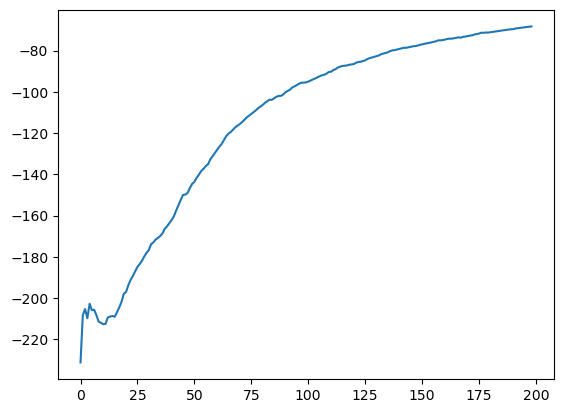

In [1]:
'''
Train a Q-value following a classical Q-learning algorithm (enforcing the
satisfaction of HJB method), using a noisy greedy exploration strategy.

The result of a training for a continuous pendulum (after 200 iterations) 
are stored in qvalue.h5.

Reference:
Mnih, Volodymyr, et al. "Human-level control through deep reinforcement learning." 
Nature 518.7540 (2015): 529.
'''

from tp7.env_pendulum import EnvPendulumHybrid; Env = lambda : EnvPendulumHybrid(1,viewer='meshcat')
from tp7.qnetwork import QNetwork
from collections import deque
import tensorflow as tf
import tensorflow.compat.v1 as tf1
import time
import signal
import matplotlib.pyplot as plt
import random
import numpy as np
tf1.enable_eager_execution()


### --- Random seed
RANDOM_SEED = int((time.time()%10)*1000)
print("Seed = %d" %  RANDOM_SEED)
np .random.seed     (RANDOM_SEED)
random.seed         (RANDOM_SEED)

### --- Environment
env                 = Env()

### --- Hyper paramaters
NEPISODES               = 200           # Max training steps
NSTEPS                  = 60            # Max episode length
QVALUE_LEARNING_RATE    = 0.001         # Base learning rate for the Q-value Network
DECAY_RATE              = 0.99          # Discount factor 
UPDATE_RATE             = 0.01          # Homotopy rate to update the networks
REPLAY_SIZE             = 10000         # Size of replay buffer
BATCH_SIZE              = 64            # Number of points to be fed in stochastic gradient
NH1 = NH2               = 32            # Hidden layer size

### --- Replay memory
class ReplayItem:
    def __init__(self,x,u,r,d,x2):
        self.x          = x
        self.u          = u
        self.reward     = r
        self.done       = d
        self.x2         = x2
replayDeque = deque()

### --- Tensor flow initialization
qvalue          = QNetwork(nx=env.nx,nu=env.nu,learning_rate=QVALUE_LEARNING_RATE)
qvalueTarget    = QNetwork(name='target',nx=env.nx,nu=env.nu)
# Uncomment to load networks
#qvalue.load()
#qvalueTarget.load()

def rendertrial(maxiter=NSTEPS,verbose=True):
    x = env.reset()
    traj = [x.copy()]
    rsum = 0.
    for i in range(maxiter):
        u = qvalue.policy(x)[0]
        x, reward = env.step(u)
        env.render()
        time.sleep(1e-2)
        rsum += reward
        traj.append(x.copy())
    if verbose: print('Lasted ',i,' timestep -- total reward:',rsum)
    return np.array(traj)
signal.signal(signal.SIGTSTP, lambda x,y:rendertrial()) # Roll-out when CTRL-Z is pressed

### History of search
h_rwd = []

### --- Training
for episode in range(1,NEPISODES):
    x    = env.reset()
    rsum = 0.0

    for step in range(NSTEPS):
        u       = qvalue.policy(x,                                     # Greedy policy ...
                                noise=1. / (1. + episode + step))      # ... with noise
        x2,r    = env.step(u)
        done    = False # Some environment may return information when task completed

        replayDeque.append(ReplayItem(x,u,r,done,x2))                # Feed replay memory ...
        if len(replayDeque)>REPLAY_SIZE: replayDeque.popleft()       # ... with FIFO forgetting.

        rsum   += r
        x       = x2
        if done: break
        
        # Start optimizing networks when memory size > batch size.
        if len(replayDeque) > BATCH_SIZE:     
            batch = random.sample(replayDeque,BATCH_SIZE)            # Random batch from replay memory.
            x_batch    = np.vstack([ b.x      for b in batch ])
            u_batch    = np.vstack([ b.u      for b in batch ])
            r_batch    = np.array([ [b.reward] for b in batch ])
            d_batch    = np.array([ [b.done]   for b in batch ])
            x2_batch   = np.vstack([ b.x2     for b in batch ])
            
            # Compute Q(x,u) from target network
            v_batch    = qvalueTarget.value(x2_batch)
            qref_batch = r_batch + (d_batch==False)*(DECAY_RATE*v_batch)

            # Update qvalue to solve HJB constraint: q = r + q'
            qvalue.trainer.train_on_batch([x_batch,u_batch],qref_batch)
            
            # Update target networks by homotopy.
            qvalueTarget.targetAssign(qvalue,UPDATE_RATE)
      
    # \\\END_FOR step in range(NSTEPS)

    # Display and logging (not mandatory).
    print('Ep#{:3d}: lasted {:d} steps, reward={:3.0f}' .format(episode, step,rsum))
    h_rwd.append(rsum)
    if not (episode+1) % 200:     rendertrial(30)

# \\\END_FOR episode in range(NEPISODES)

print("Average reward during trials: %.3f" % (sum(h_rwd)/NEPISODES))
rendertrial()
plt.plot( np.cumsum(h_rwd)/range(1,NEPISODES) )
plt.show()

# Uncomment to save networks
#qvalue.save()

## Actor critic
When the control space is discrete, the optimal policy is directly obtained by maximizing the Q value by an exhaustive search. This does not work for continuous space. In that case, a policy network must be trained in parallel, to greedily optimize the Q function. A famous algorithm for that, which is a near direct extension of Deep-Q, is the Deep Deterministic Policy Gradient (DDPG). 

Like Deep-Q, it optimizes the Q function to contract the Belman residual. To efficiently do that, it also uses minibatches to avoid the local collapses due to sample dependancy. In addition, it uses a smoothing of the gradient direction, using a so-called "target network", that can be understood as an ad-hoc trust region to avoid violent gradient steps. Finally, it greedily optimizes a policy network: one of the main trick of the paper is to compute the gradient direction of the policy network, which uses the jacobian of the value network. But in the following implementation, this is automatically computed by

RESTART YOUR JUPYTER KERNEL

2023-01-20 19:05:18.103792: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Seed = 0
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7010/static/


2023-01-20 19:05:19.997314: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-20 19:05:20.020026: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-20 19:05:20.020389: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-20 19:05:20.020973: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Ep#  0: lasted 200 steps, reward=-1136.0 
Ep#  1: lasted 200 steps, reward=-3162.9 
Ep#  2: lasted 200 steps, reward=-2842.7 
Ep#  3: lasted 200 steps, reward=-1950.9 
Ep#  4: lasted 200 steps, reward=-1912.1 
Ep#  5: lasted 200 steps, reward=-2256.0 
Ep#  6: lasted 200 steps, reward=-3392.8 
Ep#  7: lasted 200 steps, reward=-2558.7 
Ep#  8: lasted 200 steps, reward=-2177.9 
Ep#  9: lasted 200 steps, reward=-3128.3 
Ep# 10: lasted 200 steps, reward=-8.3 
Ep# 11: lasted 200 steps, reward=-1615.0 
Ep# 12: lasted 200 steps, reward=-1982.5 
Ep# 13: lasted 200 steps, reward=-1901.2 
Ep# 14: lasted 200 steps, reward=-2008.9 
Ep# 15: lasted 200 steps, reward=-1817.9 
Ep# 16: lasted 200 steps, reward=-1186.2 
Ep# 17: lasted 200 steps, reward=-1468.7 
Ep# 18: lasted 200 steps, reward=-10762.9 
Ep# 19: lasted 200 steps, reward=-2754.9 
Ep# 20: lasted 200 steps, reward=-1955.5 
Ep# 21: lasted 200 steps, reward=-1266.1 
Ep# 22: lasted 200 steps, reward=-1997.0 
Ep# 23: lasted 200 steps, reward=-22

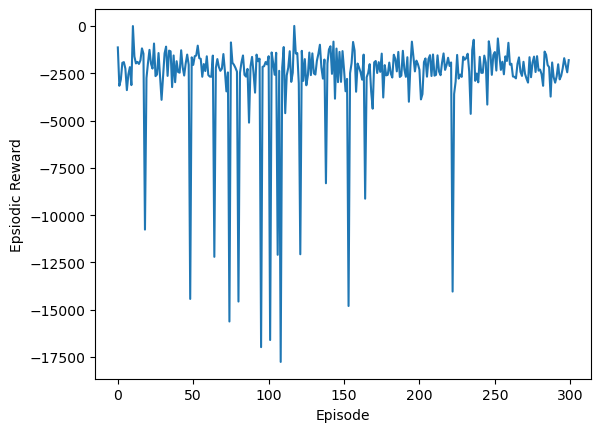

In [1]:
'''
Deep actor-critic network, 
From "Continuous control with deep reinforcement learning", by Lillicrap et al, arXiv:1509.02971
'''
from tp7.env_pendulum import EnvPendulumSinCos; Env = lambda : EnvPendulumSinCos(1,viewer='meshcat')
import gym
import tensorflow as tf
import tensorflow.compat.v1 as tf1
import tensorflow.keras as tfk
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from collections import deque
import signal

tf1.enable_eager_execution()

#######################################################################################################33
#######################################################################################################33
#######################################################################################################33
### --- Random seed
RANDOM_SEED = 0 # int((time.time()%10)*1000)
print("Seed = %d" %  RANDOM_SEED)
np .random.seed     (RANDOM_SEED)
random.seed         (RANDOM_SEED)
tf.random.set_seed  (RANDOM_SEED)

### --- Hyper paramaters
NEPISODES               = 300           # Max training steps
NSTEPS                  = 200           # Max episode length
QVALUE_LEARNING_RATE    = 0.001         # Base learning rate for the Q-value Network
POLICY_LEARNING_RATE    = 0.0001        # Base learning rate for the policy network
DECAY_RATE              = 0.99          # Discount factor 
UPDATE_RATE             = 0.01          # Homotopy rate to update the networks
REPLAY_SIZE             = 10000         # Size of replay buffer
BATCH_SIZE              = 64            # Number of points to be fed in stochastic gradient
NH1 = NH2               = 250           # Hidden layer size
EXPLORATION_NOISE       = 0.2

### --- Environment
# problem = "Pendulum-v1"
# env = gym.make(problem)
# NX = env.observation_space.shape[0]
# NU = env.action_space.shape[0]
# UMAX = env.action_space.high[0]
# env.reset(seed=RANDOM_SEED)
# assert( env.action_space.low[0]==-UMAX)

env                 = Env()             # Continuous pendulum
NX                  = env.nx            # ... training converges with q,qdot with 2x more neurones.
NU                  = env.nu            # Control is dim-1: joint torque
UMAX                = env.umax[0]       # Torque range


#######################################################################################################33
### NETWORKS ##########################################################################################33
#######################################################################################################33

class QValueNetwork:
    '''
    Neural representaion of the Quality function:
    Q:  x,y -> Q(x,u) \in R
    '''
    def __init__(self,nx,nu,nhiden1=32,nhiden2=256,learning_rate=None):

        state_input = tfk.layers.Input(shape=(nx))
        state_out = tfk.layers.Dense(nhiden1, activation="relu")(state_input)
        state_out = tfk.layers.Dense(nhiden1, activation="relu")(state_out)

        action_input = tfk.layers.Input(shape=(nu))
        action_out = tfk.layers.Dense(nhiden1, activation="relu")(action_input)

        concat = tfk.layers.Concatenate()([state_out, action_out])

        out = tfk.layers.Dense(nhiden2, activation="relu")(concat)
        out = tfk.layers.Dense(nhiden2, activation="relu")(out)
        value_output = tfk.layers.Dense(1)(out)

        self.model = tfk.Model([state_input, action_input], value_output)

    @tf.function
    def targetAssign(self,target,tau=UPDATE_RATE):
        for (tar,cur) in zip(target.model.variables,self.model.variables):
            tar.assign(cur * tau + tar * (1 - tau))
 

class PolicyNetwork:
    '''
    Neural representation of the policy function:
    Pi: x -> u=Pi(x) \in R^nu
    '''
    def __init__(self,nx,nu,umax,nhiden=32,learning_rate=None):
        random_init = tf.random_uniform_initializer(minval=-0.005, maxval=0.005)
        
        state_input = tfk.layers.Input(shape=(nx,))
        out = tfk.layers.Dense(nhiden, activation="relu")(state_input)
        out = tfk.layers.Dense(nhiden, activation="relu")(out)
        policy_output = tfk.layers.Dense(1, activation="tanh",
                                         kernel_initializer=random_init)(out)*umax
        self.model = tfk.Model(state_input, policy_output)

    @tf.function
    def targetAssign(self,target,tau=UPDATE_RATE):
        for (tar,cur) in zip(target.model.variables,self.model.variables):
            tar.assign(cur * tau + tar * (1 - tau))

    def numpyPolicy(self,x,noise=None):
        '''Eval the policy with numpy input-output (nx,)->(nu,).'''
        x_tf = tf.expand_dims(tf.convert_to_tensor(x), 0)
        u = np.squeeze(self.model(x_tf).numpy(),0)
        if noise is not None:
            u = np.clip( u+noise, -UMAX,UMAX)
        return u

    def __call__(self, x,**kwargs):
        return self.numpyPolicy(x,**kwargs)

            
        
#######################################################################################################33

class OUNoise:
    '''
    Ornstein–Uhlenbeck processes are markov random walks with the nice property to eventually
    converge to its mean.
    We use it for adding some random search at the begining of the exploration.
    '''
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, y_initial=None,dtype=np.float32):
        self.theta = theta
        self.mean = mean.astype(dtype)
        self.std_dev = std_deviation.astype(dtype)
        self.dt = dt
        self.dtype=dtype
        self.reset(y_initial)

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        noise = np.random.normal(size=self.mean.shape).astype(self.dtype)
        self.y += \
            self.theta * (self.mean - self.y) * self.dt \
            + self.std_dev * np.sqrt(self.dt) * noise
        return self.y.copy()

    def reset(self,y_initial = None):
        self.y = y_initial.astype(self.dtype) if y_initial is not None else np.zeros_like(self.mean)

### --- Replay memory
class ReplayItem:
    '''
    Storage for the minibatch
    '''
    def __init__(self,x,u,r,d,x2):
        self.x          = x
        self.u          = u
        self.reward     = r
        self.done       = d
        self.x2         = x2


#######################################################################################################33
quality = QValueNetwork(NX,NU,NH1,NH2)
qualityTarget = QValueNetwork(NX,NU,NH1,NH2)
quality.targetAssign(qualityTarget,1)

policy = PolicyNetwork(NX,NU,umax=UMAX,nhiden=NH2)
policyTarget = PolicyNetwork(NX,NU,umax=UMAX,nhiden=NH2)
policy.targetAssign(policyTarget,1)

replayDeque = deque()

ou_noise = OUNoise(mean=np.zeros(1), std_deviation=float(EXPLORATION_NOISE) * np.ones(1))
ou_noise.reset( np.array([ UMAX/2 ]) )

#######################################################################################################33
### MAIN ACTOR-CRITIC BLOCK
#######################################################################################################33

critic_optimizer = tfk.optimizers.Adam(QVALUE_LEARNING_RATE)
actor_optimizer = tfk.optimizers.Adam(POLICY_LEARNING_RATE)

@tf.function
def learn(state_batch, action_batch, reward_batch, next_state_batch):
    '''
    <learn> is isolated in a tf.function to make it more efficient.
    @tf.function forces tensorflow to optimize the inner computation graph defined in this function.
    '''

    # Automatic differentiation of the critic loss, using tf.GradientTape
    # The critic loss is the classical Q-learning loss:
    #         loss = || Q(x,u) -  (reward + Q(xnext,Pi(xnexT)) ) ||**2
    with tf.GradientTape() as tape:
        target_actions = policyTarget.model(next_state_batch, training=True)
        y = reward_batch + DECAY_RATE * qualityTarget.model(
            [next_state_batch, target_actions], training=True
        )
        critic_value = quality.model([state_batch, action_batch], training=True)
        critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))
        
    critic_grad = tape.gradient(critic_loss, quality.model.trainable_variables)
    critic_optimizer.apply_gradients(
        zip(critic_grad, quality.model.trainable_variables)
    )

    # Automatic differentiation of the actor loss, using tf.GradientTape
    # The actor loss implements a greedy optimization on the quality function
    #           loss(u) = Q(x,u)
    with tf.GradientTape() as tape:
        actions = policy.model(state_batch, training=True)
        critic_value = quality.model([state_batch, actions], training=True)
        actor_loss = -tf.math.reduce_mean(critic_value)

    actor_grad = tape.gradient(actor_loss, policy.model.trainable_variables)
    actor_optimizer.apply_gradients(
        zip(actor_grad, policy.model.trainable_variables)
    )
  

#######################################################################################################
#######################################################################################################
#######################################################################################################

def rendertrial(maxiter=NSTEPS,verbose=True):
    '''
    Display a roll-out from random start and optimal feedback.
    Press ^Z to get a roll-out at training time.
    '''
    x = env.reset()
    rsum = 0.
    for i in range(maxiter):
        u = policy(x)
        x, reward = env.step(u)[:2]
        env.render()
        rsum += reward
    if verbose: print('Lasted ',i,' timestep -- total reward:',rsum)
signal.signal(signal.SIGTSTP, lambda x,y:rendertrial()) # Roll-out when CTRL-Z is pressed
env.full.sleepAtDisplay=5e-3

# Logs
h_rewards = []
h_steps   = []

# Takes about 4 min to train
for episode in range(NEPISODES):

    prev_state = env.reset()

    for step in range(NSTEPS):
    # Uncomment this to see the Actor in action
        # But not in a python notebook.
        #env.render()

        action = policy(prev_state, noise=ou_noise())
        state, reward = env.step(action)[:2]
        done=False
        
        replayDeque.append(ReplayItem(prev_state, action, reward, done, state))
        
        prev_state = state

        if len(replayDeque) <= BATCH_SIZE:  continue


        ####################################################################
        # Sample a minibatch
        
        batch = random.sample(replayDeque,BATCH_SIZE)            # Random batch from replay memory.
        state_batch    = tf.convert_to_tensor([ b.x      for b in batch ])
        action_batch    = tf.convert_to_tensor([ b.u      for b in batch ])
        reward_batch    = tf.convert_to_tensor([ [ b.reward ] for b in batch ],dtype=np.float32)
        done_batch    = tf.convert_to_tensor([ b.done   for b in batch ])
        next_state_batch   = tf.convert_to_tensor([ b.x2     for b in batch ])

        ####################################################################
        # One gradient step for the minibatch

        # Critic and actor gradients
        learn(state_batch, action_batch, reward_batch, next_state_batch)
        # Step smoothing using target networks
        policy.targetAssign(policyTarget)
        quality.targetAssign(qualityTarget)

        if done: break   # stop at episode end.

    # Some prints and logs
    episodic_reward = sum([ replayDeque[-i-1].reward for i in range(step+1) ])
    h_rewards.append( episodic_reward )
    h_steps.append(step+1)
    
    print(f'Ep#{episode:3d}: lasted {step+1:d} steps, reward={episodic_reward:3.1f} ')

    
    # avg_reward = np.mean(h_rewards[-40:])
    # if episode==5 and RANDOM_SEED==0:
    #     assert(  abs(avg_reward + 1423.0528188196286) < 1e-3 )
    # if episode==0 and RANDOM_SEED==0:
    #     assert(  abs(avg_reward + 1712.386325099637) < 1e-3 )
        
# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(h_rewards)
plt.xlabel("Episode")
plt.ylabel("Epsiodic Reward")
plt.show()

#######################################################################################################33
#######################################################################################################33
#######################################################################################################33
